In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
import os
import sys
from pathlib import Path, PurePath
sys.path.append("..")
# For quicksort
sys.setrecursionlimit(int(1e7))

from src.linear_sorting_algorithms import radixsort
from src.quadratic_sorting_algorithms import bubble_sort, insertion_sort
from src.subquad_sorting_algorithms import quicksort, mergesort
from src.combined_sorting_algorithm import mergesort_combined

from src.utility import time_sorting_algorithms, ArrayGenerator

os.getcwd()
import matplotlib.pyplot as plt




In [43]:
if Path('../visuals').exists():
    viz_directory = PurePath("../visuals")
    print(viz_directory)

..\visuals


### Generating data from 1, 2, 3 ... 1000.

In [19]:
array_gen = ArrayGenerator(seed=None)

# N for 2-base generator, N^2
N = 1000
cols = {"Ascending" : np.single, "Descending" : np.single, "Random" : np.single, "Structured" : np.single, "Integers" :np.int32}

test_data = dict()


for i in range(2, N+1, 1):
    # Inverse of 2^N to create small steps
    n = i
    i = math.log2(i)
    
    data = np.array([array_gen.sorted_array(i),
            array_gen.reversed_array(i),
            array_gen.random_array(i),
            array_gen.structured_array(i),
            array_gen.integer_array(i)
           ])
    test_data[n] = pd.DataFrame(columns=cols.keys(), data=data.T).astype(cols)

In [20]:
len(test_data)

999

### Timing insertion sort and merge sort on the same arrays
**Timing on Ascending, Descending, Random, Structured, Integers**

In [21]:
list_of_algorithms = [insertion_sort, mergesort]

df_results = pd.DataFrame(columns=["Algorithm", "N", "TypeArray", "Time"])

for N, Array in test_data.items():
    for TypeArray in cols.keys():
        
        for algorithm, times in time_sorting_algorithms(
            functions=list_of_algorithms, 
            array=Array[TypeArray].to_numpy(), 
            iters=5, 
            verbose=False
        ).items():
            
            for time in times:
                
                df_results = df_results.append(
                    {
                    "Algorithm": algorithm, "N": N, "TypeArray": TypeArray, "Time": time
                    }, 
                    ignore_index=True
                ) 
    if N % 100 == 0:
        print(f"Timed and gather result for up to {N} element arrays")

Timed and gather result for up to 100 element arrays
Timed and gather result for up to 200 element arrays
Timed and gather result for up to 300 element arrays
Timed and gather result for up to 400 element arrays
Timed and gather result for up to 500 element arrays
Timed and gather result for up to 600 element arrays
Timed and gather result for up to 700 element arrays
Timed and gather result for up to 800 element arrays
Timed and gather result for up to 900 element arrays
Timed and gather result for up to 1000 element arrays


In [22]:
df_results["time/n(us)"] = ((df_results['Time']/df_results['N'])*1e6).to_numpy(dtype='float32')

In [23]:
df_results.dtypes

Algorithm      object
N              object
TypeArray      object
Time          float64
time/n(us)    float32
dtype: object

In [24]:
df_results.N = df_results.N.to_numpy(dtype='int32')

In [25]:
df_results.head()

,Algorithm,N,TypeArray,Time,time/n(us)
0,insertion_sort,2,Ascending,6.577000e-04,328.850006
1,insertion_sort,2,Ascending,2.500000e-06,1.250000
2,insertion_sort,2,Ascending,6.999999e-07,0.350000
3,insertion_sort,2,Ascending,6.999999e-07,0.350000
4,insertion_sort,2,Ascending,6.999999e-07,0.350000


In [44]:
height=50
width=84
IMAGE_SIZE = (width/25.4, height/25.4)

plt.rcParams['axes.titlesize'] = 7
plt.rcParams['axes.labelsize'] = 7
plt.rcParams['xtick.labelsize'] = 7
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['legend.fontsize'] = 3
plt.rcParams["legend.markerscale"] = 0.6
plt.rcParams['legend.title_fontsize'] = 4
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 3
sns.set_style("darkgrid")

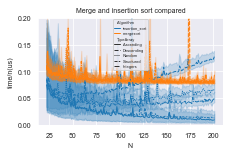

In [45]:
plt.figure(figsize=IMAGE_SIZE)
sns.lineplot(
    data=df_results.iloc[1000:10000], 
    x="N", y="time/n(us)", hue="Algorithm", style="TypeArray")
plt.title("Merge and insertion sort compared")
plt.ylim(0, 0.2)
plt.savefig(f"{viz_directory}/optimizing.pdf", bbox_inches='tight', transparent=True)

In [46]:
mean_df = df_results.groupby(['Algorithm','N']).mean()
mean_df.index.get_level_values('N')

Int64Index([   2,    3,    4,    5,    6,    7,    8,    9,   10,   11,
            ...
             991,  992,  993,  994,  995,  996,  997,  998,  999, 1000],
           dtype='int64', name='N', length=1998)

In [47]:
mean_df = mean_df[(mean_df.index.get_level_values('N') > 20) & (mean_df.index.get_level_values('N') < 500)]

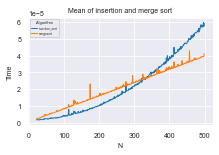

In [48]:
plt.figure(figsize=IMAGE_SIZE)
sns.lineplot(
    data=mean_df, 
    x="N", y="Time", hue="Algorithm")
plt.title("Mean of insertion and merge sort")
plt.savefig(f"{viz_directory}/optimizing_combined_threshold.pdf", bbox_inches='tight', transparent=True)
plt.show()

In [49]:
delta_series = (mean_df.loc['mergesort', '3':].Time - mean_df.loc['insertion_sort', '3':].Time)
delta_series

N
21     5.080001e-07
22     5.679999e-07
23     8.840000e-07
24     6.639998e-07
25     6.720000e-07
           ...     
495   -1.882000e-05
496   -1.793600e-05
497   -2.015200e-05
498   -1.777600e-05
499   -1.803200e-05
Name: Time, Length: 479, dtype: float64

In [50]:
delta_series.idxmax()

174

In [51]:
np.amax(delta_series)

1.4928000055078883e-05

### Found in an earlier version 142
Which also visually seems like the best threshold from the plots above

In [52]:
delta_series.sort_values(ascending=False).head(10)

N
174    0.000015
132    0.000007
202    0.000007
295    0.000007
128    0.000007
192    0.000007
138    0.000006
198    0.000006
133    0.000006
182    0.000006
Name: Time, dtype: float64

## Using $\Delta$ we have found the optimal threshold
**The results are averaged over all the different types of array, including best case and worst case for insertion sort**

We will use 142 as the threshold for using insertion sort

**note:** all functions have been Just in time compiled by numba jit function